# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:46<00:00, 1.30KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

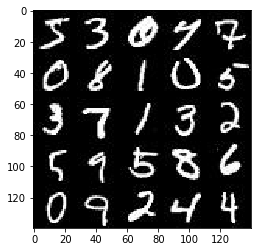

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

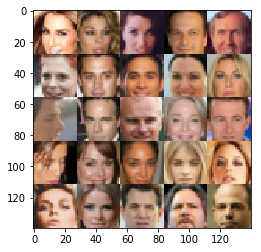

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/arturops/anaconda3/envs/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [122]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_image = tf.placeholder(dtype=tf.float32,\
                                      shape=[None, image_width, image_height, image_channels], name='real_input')
    z = tf.placeholder(tf.float32, [None, z_dim], 'z_input')
    learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')

    return real_input_image, z, learning_rate
    #return None, None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [123]:
def leakyReLU(linear_input, alpha):
    """
    leakyReLU:  function that using a linear input returns a leaky ReLU activation
    argumets:
    @linear_input: input to the function. MUST be linear
    @alpha: slope applied to the linear input. MUST be less than 1. If equal to 1 the output is a linear
    and if greater than one (the positive side explodes)
    
    Notice that in the negative part of the linear input, multiplying by a slope < 1 (i.e. alpha<1),
    the negative side alpha*linear_input > linear_input value.
    """
    output = tf.maximum(alpha*linear_input, linear_input)
    return output

def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        
        linear_act = None
        #input to discrimator has no batch norm
        # input size 28x28x3
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=linear_act)
        conv1 = leakyReLU(conv1, alpha)
        # 14x14x64
        
        #second layer
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same', activation=linear_act)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = leakyReLU(conv2, alpha)
        # 7x7x128
        
        #third layer
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=1, padding='same', activation=linear_act)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = leakyReLU(conv3, alpha)
        # 3x3x256
        
        #flatten to use fully connected layer
        flatten = tf.reshape(conv3, (-1,7*7*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits, 'output')
        
        return output, logits
    #return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [124]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = True
    if is_train:
        reuse = False
    
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        
        # fully connected input layer
        flat = tf.layers.dense(z, 7*7*256)
        
        # reshape input to start generating images
        x = tf.reshape(flat,(-1,7,7,256))
        x = tf.layers.batch_normalization(x, training=is_train) 
        x = leakyReLU(x,alpha)
        # 3x3x256
        
        # layer 1 - upsample,conv, batch_norm, leaky ReLU
        upsample1 = tf.image.resize_nearest_neighbor(x,(14,14))
        linear_conv1 = tf.layers.conv2d(upsample1,128, kernel_size=(5,5), strides=(2,2), padding='same')
        batch_norm1 = tf.layers.batch_normalization(linear_conv1, training=is_train)
        conv1 = leakyReLU(batch_norm1, alpha)
        # 7x7x128
        
        # layer 2 - upsample,conv, batch_norm, leaky ReLU
        upsample2 = tf.image.resize_nearest_neighbor(conv1,(28,28))
        linear_conv2 = tf.layers.conv2d(upsample2, 64, (5,5), (2,2), 'same')
        batch_norm2 = tf.layers.batch_normalization(linear_conv2, training=is_train)
        conv2 = leakyReLU(batch_norm2, alpha)
        # 14x14x64
        
        # layer 3 - upsample,conv
        upsample3 = tf.image.resize_nearest_neighbor(conv2, (28,28))
        linear_conv3 = tf.layers.conv2d(upsample3, out_channel_dim, 5, (1,1), 'same')
        
        #tanh
        output = tf.tanh(linear_conv3, 'output')
    
        return output
        #return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [125]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_output = generator(input_z, out_channel_dim, is_train=True)
    
    discriminator_real_output, discriminator_real_logits = discriminator(input_real, reuse=False)
    discriminator_fake_output, discriminator_fake_logits = discriminator(generator_output, reuse=True)
    
    discriminator_real_loss = tf.reduce_mean(
                                            tf.nn.sigmoid_cross_entropy_with_logits(
                                                logits=discriminator_real_logits,
                                                labels=tf.ones_like(discriminator_real_output)*0.9
                                            )
    )
    discriminator_fake_loss = tf.reduce_mean(
                                            tf.nn.sigmoid_cross_entropy_with_logits(
                                                logits=discriminator_fake_logits,
                                                labels=tf.zeros_like(discriminator_fake_output)
                                            )
    )
    generator_loss = tf.reduce_mean(
                                    tf.nn.sigmoid_cross_entropy_with_logits(
                                        logits=discriminator_fake_output,
                                        labels=tf.ones_like(discriminator_fake_output)
                                    )
    )
    
    
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [141]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Separate vars of generator and discriminator
    tf_vars = tf.trainable_variables()
    generator_vars     = [var for var in tf_vars if var.name.startswith('generator')]
    discriminator_vars = [var for var in tf_vars if var.name.startswith('discriminator')]
    
    #Optimization
    d_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    g_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    
    
    with tf.control_dependencies(d_update_ops):
        discriminator_train = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss,var_list= discriminator_vars)
    with tf.control_dependencies(g_update_ops):
        generator_train = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss,var_list= generator_vars)
    
    return discriminator_train, generator_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [142]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [144]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, checkpoint):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    #CONSTANTS
    PRINT_EVERY_STEPS = batch_size//2
    SHOW_G_EXAMPLE = batch_size
    
    # Building the GAN Model
    # reset graph in every new run
    #tf.reset_default_graph()
    
    total_batches = data_shape[0]
    img_width = data_shape[1]
    img_height = data_shape[2]
    out_channel_dim = data_shape[3]
    
    input_real, input_z, lr = model_inputs(img_width, img_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    #sample_z = np.random.uniform(-0.5,0.5,size=(batch_size,z_dim))
    
    steps=0
    losses = []
 
    
    # Start the Training
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model Steps
                steps += 1
                batch_images*=2 #to make the range go from -0.5 to 0.5
                # Sample random noise for G
                #batch_z = np.random.uniform(-0.5,0.5,size=(batch_size,z_dim))
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                
                #Prints the loss numbers
                if steps % PRINT_EVERY_STEPS == 0:
                    train_d_loss = d_loss.eval({input_real:batch_images, input_z:batch_z})#, learning_rate:learning_rate})
                    train_g_loss = g_loss.eval({input_z:batch_z})#, learning_rate:learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{}...".format(steps, total_batches),
                          "Discriminator loss {:.4f}...".format(train_d_loss),
                          "Generator loss {:.4f}".format(train_g_loss)
                         )
                    #store losses for future display
                    losses.append((train_d_loss, train_g_loss))
                
                #Shows an example of an output of the Generator, to see how it is learning
                if steps % SHOW_G_EXAMPLE == 0:
                    #To get an example we run a generator
                    #g_example = sess.run(generator(input_z, out_channel_dim, is_Train=False),
                    #                    feed_dict={input_z:sample_z}
                    #                    )

                    
                    #show example images
                    show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)
                    
        
        checkpoint_name = './checkpoints/generator_'+checkpoint+'.ckpt'
        saver.save(sess,checkpoint_name) #'./checkpoints/generator.ckpt')
        print('Checkpoint {} saved.'.format(checkpoint_name))
        
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 32/60000... Discriminator loss 2.2171... Generator loss 0.4008
Epoch 1/2... Batch 64/60000... Discriminator loss 1.4690... Generator loss 0.4947


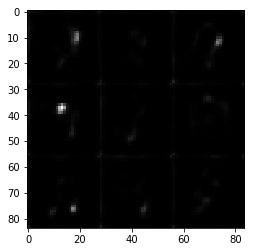

Epoch 1/2... Batch 96/60000... Discriminator loss 1.6838... Generator loss 0.4435
Epoch 1/2... Batch 128/60000... Discriminator loss 1.5260... Generator loss 0.4403


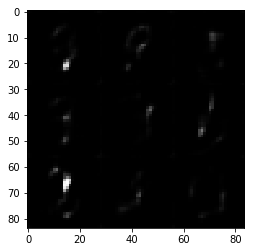

Epoch 1/2... Batch 160/60000... Discriminator loss 1.7563... Generator loss 0.5023
Epoch 1/2... Batch 192/60000... Discriminator loss 1.4016... Generator loss 0.5844


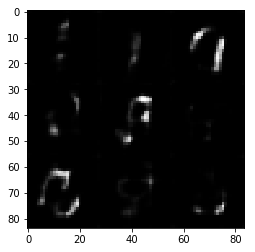

Epoch 1/2... Batch 224/60000... Discriminator loss 1.4258... Generator loss 0.5676
Epoch 1/2... Batch 256/60000... Discriminator loss 1.3832... Generator loss 0.5705


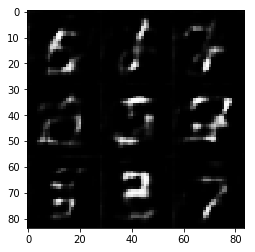

Epoch 1/2... Batch 288/60000... Discriminator loss 1.4278... Generator loss 0.4498
Epoch 1/2... Batch 320/60000... Discriminator loss 1.5852... Generator loss 0.4372


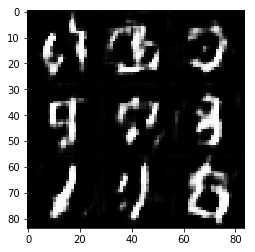

Epoch 1/2... Batch 352/60000... Discriminator loss 2.2821... Generator loss 0.3722
Epoch 1/2... Batch 384/60000... Discriminator loss 1.4271... Generator loss 0.5019


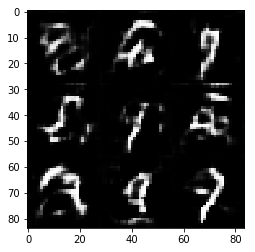

Epoch 1/2... Batch 416/60000... Discriminator loss 1.5780... Generator loss 0.4228
Epoch 1/2... Batch 448/60000... Discriminator loss 1.2221... Generator loss 0.5082


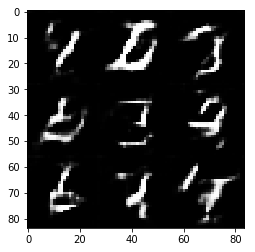

Epoch 1/2... Batch 480/60000... Discriminator loss 1.6813... Generator loss 0.4203
Epoch 1/2... Batch 512/60000... Discriminator loss 1.5724... Generator loss 0.4582


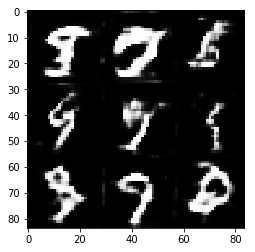

Epoch 1/2... Batch 544/60000... Discriminator loss 1.6275... Generator loss 0.4251
Epoch 1/2... Batch 576/60000... Discriminator loss 1.2564... Generator loss 0.5206


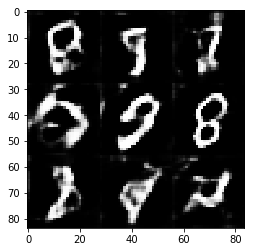

Epoch 1/2... Batch 608/60000... Discriminator loss 1.3943... Generator loss 0.4604
Epoch 1/2... Batch 640/60000... Discriminator loss 1.3081... Generator loss 0.5863


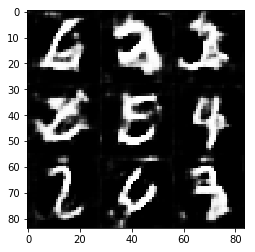

Epoch 1/2... Batch 672/60000... Discriminator loss 1.7766... Generator loss 0.3998
Epoch 1/2... Batch 704/60000... Discriminator loss 1.1337... Generator loss 0.5842


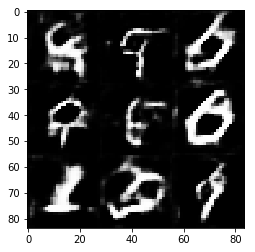

Epoch 1/2... Batch 736/60000... Discriminator loss 1.2304... Generator loss 0.4969
Epoch 1/2... Batch 768/60000... Discriminator loss 1.6641... Generator loss 0.4106


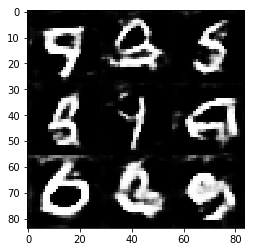

Epoch 1/2... Batch 800/60000... Discriminator loss 1.4315... Generator loss 0.4350
Epoch 1/2... Batch 832/60000... Discriminator loss 1.2782... Generator loss 0.6137


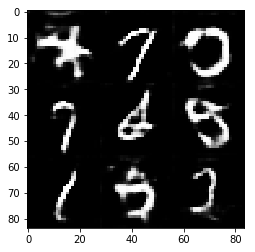

Epoch 1/2... Batch 864/60000... Discriminator loss 1.3438... Generator loss 0.4841
Epoch 1/2... Batch 896/60000... Discriminator loss 1.1222... Generator loss 0.5316


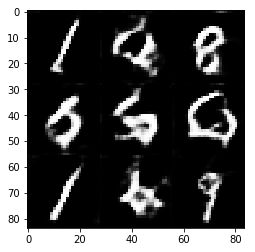

Epoch 1/2... Batch 928/60000... Discriminator loss 1.3068... Generator loss 0.6138
Epoch 2/2... Batch 960/60000... Discriminator loss 1.3270... Generator loss 0.4593


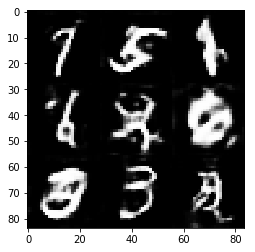

Epoch 2/2... Batch 992/60000... Discriminator loss 1.4063... Generator loss 0.4529
Epoch 2/2... Batch 1024/60000... Discriminator loss 1.1620... Generator loss 0.4951


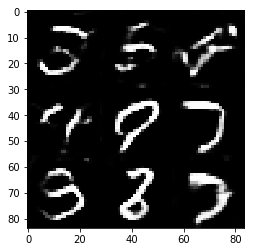

Epoch 2/2... Batch 1056/60000... Discriminator loss 1.2531... Generator loss 0.5737
Epoch 2/2... Batch 1088/60000... Discriminator loss 1.3492... Generator loss 0.4719


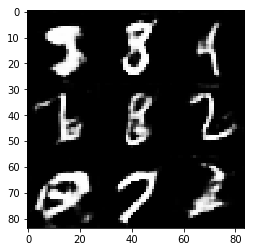

Epoch 2/2... Batch 1120/60000... Discriminator loss 1.3348... Generator loss 0.4828
Epoch 2/2... Batch 1152/60000... Discriminator loss 1.6825... Generator loss 0.6561


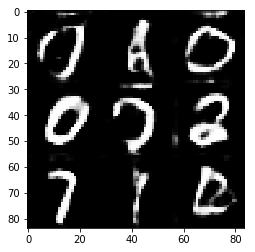

Epoch 2/2... Batch 1184/60000... Discriminator loss 1.0850... Generator loss 0.5324
Epoch 2/2... Batch 1216/60000... Discriminator loss 1.1374... Generator loss 0.5037


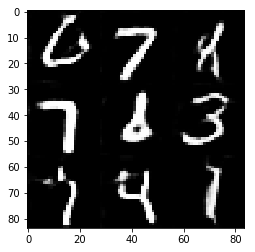

Epoch 2/2... Batch 1248/60000... Discriminator loss 0.9617... Generator loss 0.5225
Epoch 2/2... Batch 1280/60000... Discriminator loss 1.4215... Generator loss 0.4479


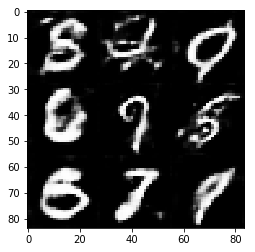

Epoch 2/2... Batch 1312/60000... Discriminator loss 1.4581... Generator loss 0.4382
Epoch 2/2... Batch 1344/60000... Discriminator loss 0.9024... Generator loss 0.6115


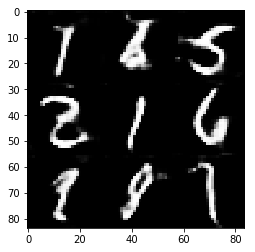

Epoch 2/2... Batch 1376/60000... Discriminator loss 0.8579... Generator loss 0.5690
Epoch 2/2... Batch 1408/60000... Discriminator loss 1.4797... Generator loss 0.4535


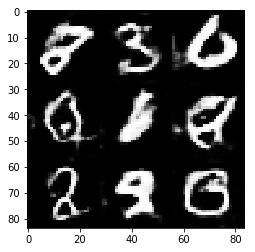

Epoch 2/2... Batch 1440/60000... Discriminator loss 0.7512... Generator loss 0.6428
Epoch 2/2... Batch 1472/60000... Discriminator loss 0.8560... Generator loss 0.5695


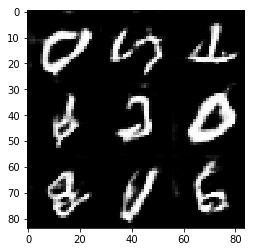

Epoch 2/2... Batch 1504/60000... Discriminator loss 1.2852... Generator loss 0.5155
Epoch 2/2... Batch 1536/60000... Discriminator loss 1.0119... Generator loss 0.5269


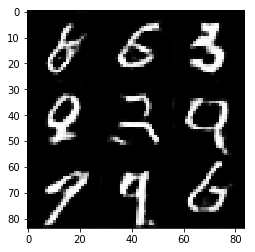

Epoch 2/2... Batch 1568/60000... Discriminator loss 1.1766... Generator loss 0.4833
Epoch 2/2... Batch 1600/60000... Discriminator loss 1.2744... Generator loss 0.4714


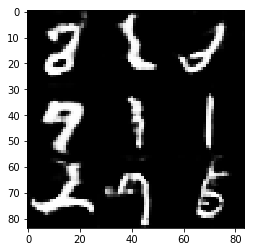

Epoch 2/2... Batch 1632/60000... Discriminator loss 1.0665... Generator loss 0.5071
Epoch 2/2... Batch 1664/60000... Discriminator loss 1.1236... Generator loss 0.5034


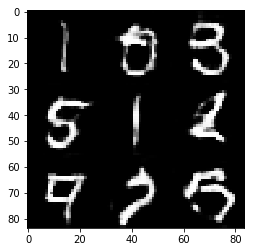

Epoch 2/2... Batch 1696/60000... Discriminator loss 0.8883... Generator loss 0.6291
Epoch 2/2... Batch 1728/60000... Discriminator loss 2.2353... Generator loss 0.3936


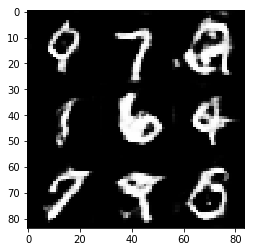

Epoch 2/2... Batch 1760/60000... Discriminator loss 1.1517... Generator loss 0.5978
Epoch 2/2... Batch 1792/60000... Discriminator loss 0.7963... Generator loss 0.5852


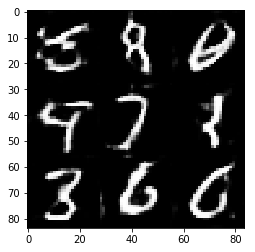

Epoch 2/2... Batch 1824/60000... Discriminator loss 0.8386... Generator loss 0.6470
Epoch 2/2... Batch 1856/60000... Discriminator loss 0.8048... Generator loss 0.6428


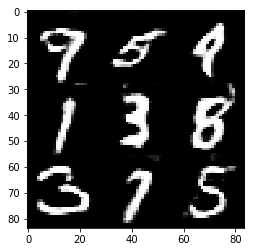

Checkpoint ./checkpoints/generator_mnist.ckpt saved.


In [145]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

#tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, 'mnist')

# CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 32/202599... Discriminator loss 2.5587... Generator loss 0.4925
Epoch 1/1... Batch 64/202599... Discriminator loss 1.0325... Generator loss 0.5415


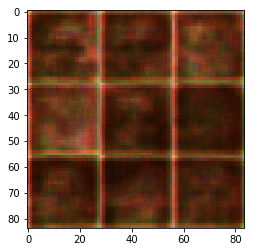

Epoch 1/1... Batch 96/202599... Discriminator loss 1.5648... Generator loss 0.4633
Epoch 1/1... Batch 128/202599... Discriminator loss 0.8674... Generator loss 0.5956


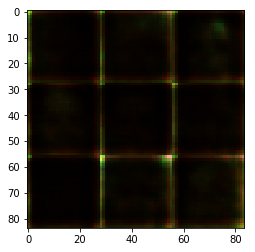

Epoch 1/1... Batch 160/202599... Discriminator loss 1.2035... Generator loss 0.4896
Epoch 1/1... Batch 192/202599... Discriminator loss 0.8906... Generator loss 0.5707


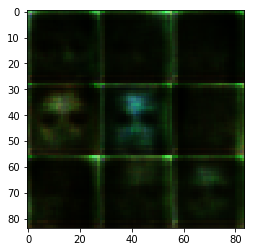

Epoch 1/1... Batch 224/202599... Discriminator loss 1.1911... Generator loss 0.4967
Epoch 1/1... Batch 256/202599... Discriminator loss 1.7746... Generator loss 0.6861


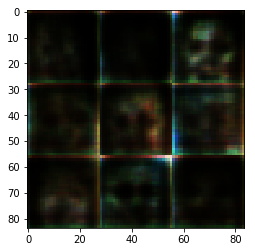

Epoch 1/1... Batch 288/202599... Discriminator loss 1.5935... Generator loss 0.4495
Epoch 1/1... Batch 320/202599... Discriminator loss 0.6651... Generator loss 0.6375


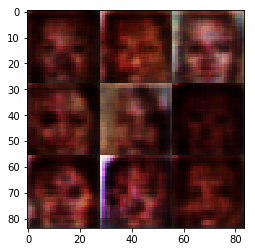

Epoch 1/1... Batch 352/202599... Discriminator loss 1.3174... Generator loss 0.4852
Epoch 1/1... Batch 384/202599... Discriminator loss 1.2839... Generator loss 0.4940


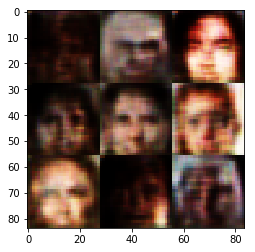

Epoch 1/1... Batch 416/202599... Discriminator loss 0.6569... Generator loss 0.6075
Epoch 1/1... Batch 448/202599... Discriminator loss 1.2013... Generator loss 0.5284


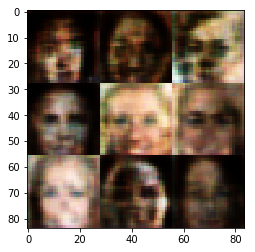

Epoch 1/1... Batch 480/202599... Discriminator loss 1.4176... Generator loss 0.5115
Epoch 1/1... Batch 512/202599... Discriminator loss 1.5283... Generator loss 0.4595


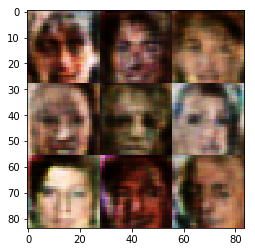

Epoch 1/1... Batch 544/202599... Discriminator loss 1.0599... Generator loss 0.5157
Epoch 1/1... Batch 576/202599... Discriminator loss 1.5765... Generator loss 0.4343


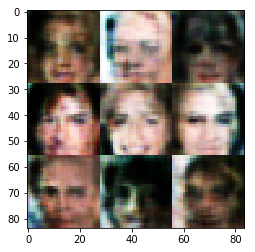

Epoch 1/1... Batch 608/202599... Discriminator loss 1.6920... Generator loss 0.4217
Epoch 1/1... Batch 640/202599... Discriminator loss 1.3199... Generator loss 0.4846


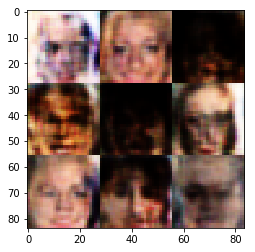

Epoch 1/1... Batch 672/202599... Discriminator loss 1.3688... Generator loss 0.4971
Epoch 1/1... Batch 704/202599... Discriminator loss 1.3877... Generator loss 0.4900


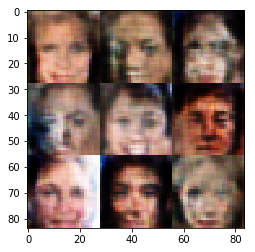

Epoch 1/1... Batch 736/202599... Discriminator loss 1.1466... Generator loss 0.5281
Epoch 1/1... Batch 768/202599... Discriminator loss 1.5639... Generator loss 0.4369


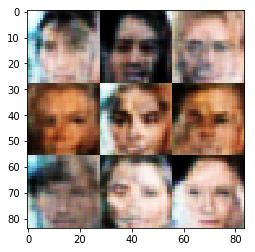

Epoch 1/1... Batch 800/202599... Discriminator loss 1.5202... Generator loss 0.4389
Epoch 1/1... Batch 832/202599... Discriminator loss 1.1039... Generator loss 0.5674


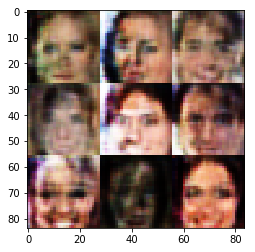

Epoch 1/1... Batch 864/202599... Discriminator loss 1.2507... Generator loss 0.4763
Epoch 1/1... Batch 896/202599... Discriminator loss 1.2268... Generator loss 0.4935


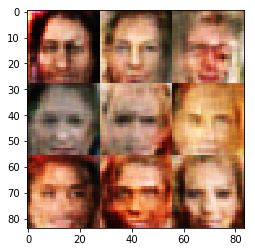

Epoch 1/1... Batch 928/202599... Discriminator loss 1.3224... Generator loss 0.5752
Epoch 1/1... Batch 960/202599... Discriminator loss 1.3135... Generator loss 0.4637


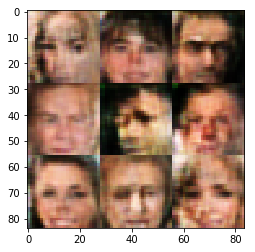

Epoch 1/1... Batch 992/202599... Discriminator loss 1.2030... Generator loss 0.4950
Epoch 1/1... Batch 1024/202599... Discriminator loss 0.9734... Generator loss 0.6083


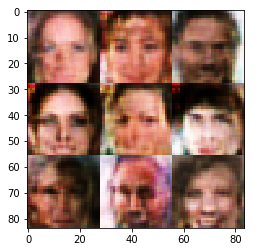

Epoch 1/1... Batch 1056/202599... Discriminator loss 1.0339... Generator loss 0.5107
Epoch 1/1... Batch 1088/202599... Discriminator loss 0.8617... Generator loss 0.5574


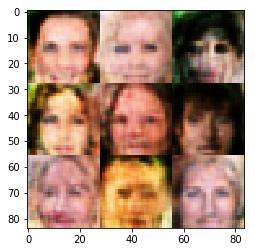

Epoch 1/1... Batch 1120/202599... Discriminator loss 0.8120... Generator loss 0.5583
Epoch 1/1... Batch 1152/202599... Discriminator loss 0.9706... Generator loss 0.5793


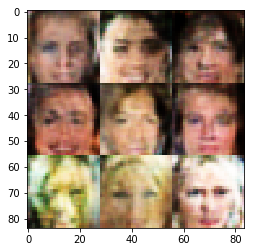

Epoch 1/1... Batch 1184/202599... Discriminator loss 0.9006... Generator loss 0.6548
Epoch 1/1... Batch 1216/202599... Discriminator loss 0.9655... Generator loss 0.6655


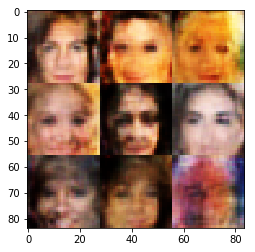

Epoch 1/1... Batch 1248/202599... Discriminator loss 1.0709... Generator loss 0.5035
Epoch 1/1... Batch 1280/202599... Discriminator loss 0.8801... Generator loss 0.5340


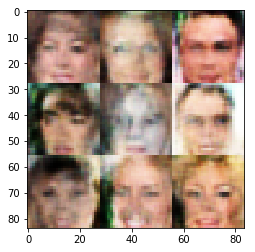

Epoch 1/1... Batch 1312/202599... Discriminator loss 1.6514... Generator loss 0.4357
Epoch 1/1... Batch 1344/202599... Discriminator loss 1.0079... Generator loss 0.5554


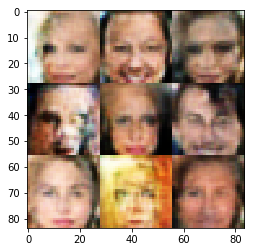

Epoch 1/1... Batch 1376/202599... Discriminator loss 0.8436... Generator loss 0.5668
Epoch 1/1... Batch 1408/202599... Discriminator loss 1.0549... Generator loss 0.5031


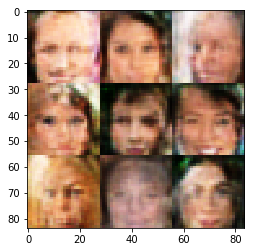

Epoch 1/1... Batch 1440/202599... Discriminator loss 0.9306... Generator loss 0.5568
Epoch 1/1... Batch 1472/202599... Discriminator loss 1.1843... Generator loss 0.4829


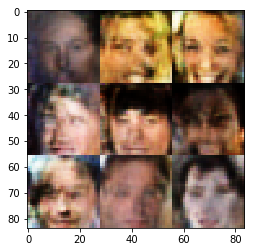

Epoch 1/1... Batch 1504/202599... Discriminator loss 1.3787... Generator loss 0.4425
Epoch 1/1... Batch 1536/202599... Discriminator loss 0.8640... Generator loss 0.5464


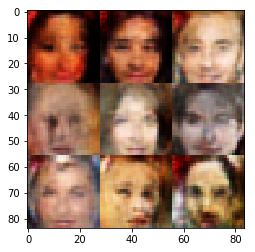

Epoch 1/1... Batch 1568/202599... Discriminator loss 1.1213... Generator loss 0.5203
Epoch 1/1... Batch 1600/202599... Discriminator loss 0.7822... Generator loss 0.5977


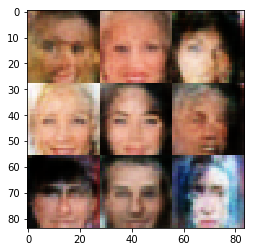

Epoch 1/1... Batch 1632/202599... Discriminator loss 0.8993... Generator loss 0.5345
Epoch 1/1... Batch 1664/202599... Discriminator loss 1.0664... Generator loss 0.4964


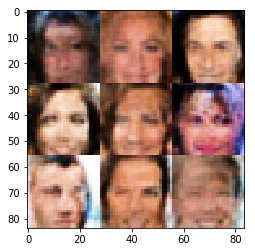

Epoch 1/1... Batch 1696/202599... Discriminator loss 0.9326... Generator loss 0.5321
Epoch 1/1... Batch 1728/202599... Discriminator loss 0.6143... Generator loss 0.6320


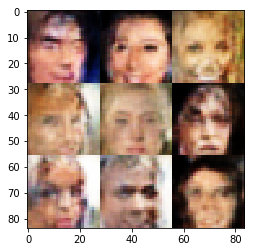

Epoch 1/1... Batch 1760/202599... Discriminator loss 0.6864... Generator loss 0.6422
Epoch 1/1... Batch 1792/202599... Discriminator loss 1.2699... Generator loss 0.4818


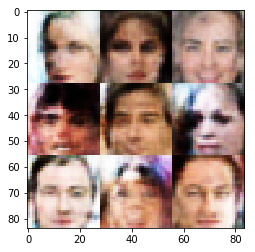

Epoch 1/1... Batch 1824/202599... Discriminator loss 0.8957... Generator loss 0.6491
Epoch 1/1... Batch 1856/202599... Discriminator loss 0.8424... Generator loss 0.6368


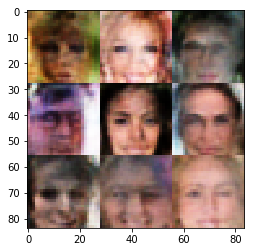

Epoch 1/1... Batch 1888/202599... Discriminator loss 1.8611... Generator loss 0.3986
Epoch 1/1... Batch 1920/202599... Discriminator loss 1.3481... Generator loss 0.4452


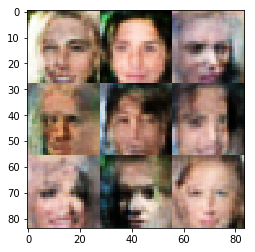

Epoch 1/1... Batch 1952/202599... Discriminator loss 2.3076... Generator loss 0.6901
Epoch 1/1... Batch 1984/202599... Discriminator loss 1.2953... Generator loss 0.4727


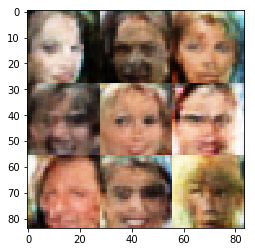

Epoch 1/1... Batch 2016/202599... Discriminator loss 1.1064... Generator loss 0.4945
Epoch 1/1... Batch 2048/202599... Discriminator loss 1.0635... Generator loss 0.5004


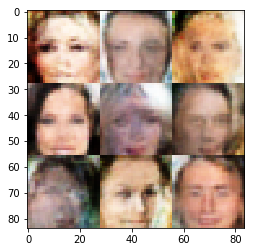

Epoch 1/1... Batch 2080/202599... Discriminator loss 1.4691... Generator loss 0.4308
Epoch 1/1... Batch 2112/202599... Discriminator loss 1.1778... Generator loss 0.4859


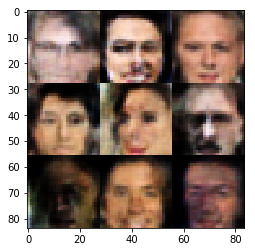

Epoch 1/1... Batch 2144/202599... Discriminator loss 0.8011... Generator loss 0.6802
Epoch 1/1... Batch 2176/202599... Discriminator loss 0.9434... Generator loss 0.5117


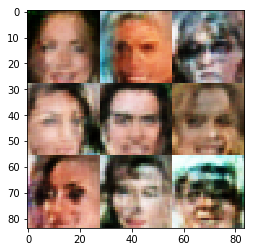

Epoch 1/1... Batch 2208/202599... Discriminator loss 0.6731... Generator loss 0.6698
Epoch 1/1... Batch 2240/202599... Discriminator loss 0.7451... Generator loss 0.6206


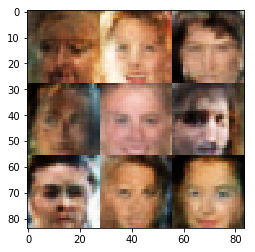

Epoch 1/1... Batch 2272/202599... Discriminator loss 1.3195... Generator loss 0.4544
Epoch 1/1... Batch 2304/202599... Discriminator loss 2.0137... Generator loss 0.4087


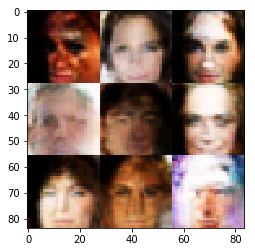

Epoch 1/1... Batch 2336/202599... Discriminator loss 0.7812... Generator loss 0.5893
Epoch 1/1... Batch 2368/202599... Discriminator loss 0.9914... Generator loss 0.5035


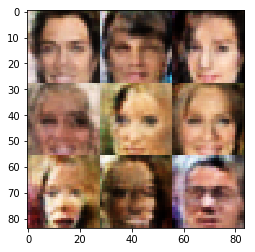

Epoch 1/1... Batch 2400/202599... Discriminator loss 0.6842... Generator loss 0.5822
Epoch 1/1... Batch 2432/202599... Discriminator loss 1.0588... Generator loss 0.4917


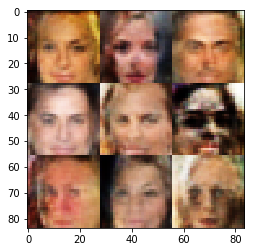

Epoch 1/1... Batch 2464/202599... Discriminator loss 0.6817... Generator loss 0.5931
Epoch 1/1... Batch 2496/202599... Discriminator loss 0.5197... Generator loss 0.6522


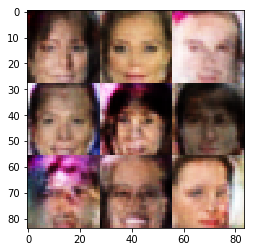

Epoch 1/1... Batch 2528/202599... Discriminator loss 1.5612... Generator loss 0.4246
Epoch 1/1... Batch 2560/202599... Discriminator loss 1.4210... Generator loss 0.6895


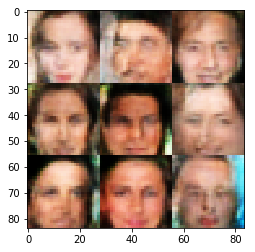

Epoch 1/1... Batch 2592/202599... Discriminator loss 0.6328... Generator loss 0.6859
Epoch 1/1... Batch 2624/202599... Discriminator loss 2.7975... Generator loss 0.3501


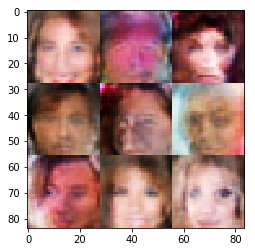

Epoch 1/1... Batch 2656/202599... Discriminator loss 0.7877... Generator loss 0.5763
Epoch 1/1... Batch 2688/202599... Discriminator loss 0.7528... Generator loss 0.5908


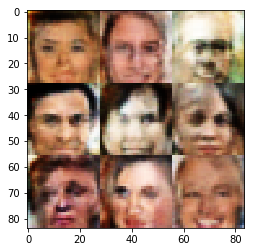

Epoch 1/1... Batch 2720/202599... Discriminator loss 2.3006... Generator loss 0.3721
Epoch 1/1... Batch 2752/202599... Discriminator loss 0.7999... Generator loss 0.5858


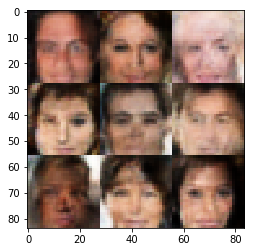

Epoch 1/1... Batch 2784/202599... Discriminator loss 1.0555... Generator loss 0.4947
Epoch 1/1... Batch 2816/202599... Discriminator loss 0.6910... Generator loss 0.6893


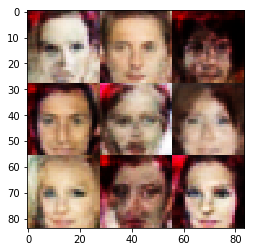

Epoch 1/1... Batch 2848/202599... Discriminator loss 0.7354... Generator loss 0.5649
Epoch 1/1... Batch 2880/202599... Discriminator loss 1.4109... Generator loss 0.4359


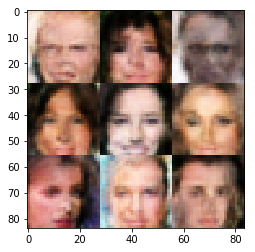

Epoch 1/1... Batch 2912/202599... Discriminator loss 0.7234... Generator loss 0.6104
Epoch 1/1... Batch 2944/202599... Discriminator loss 0.9408... Generator loss 0.6569


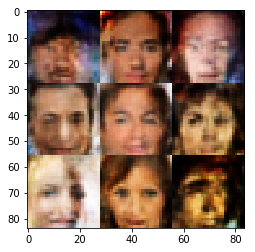

Epoch 1/1... Batch 2976/202599... Discriminator loss 0.7420... Generator loss 0.6000
Epoch 1/1... Batch 3008/202599... Discriminator loss 1.0110... Generator loss 0.6778


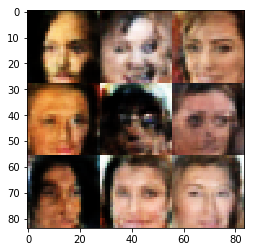

Epoch 1/1... Batch 3040/202599... Discriminator loss 0.9418... Generator loss 0.5134
Epoch 1/1... Batch 3072/202599... Discriminator loss 1.5303... Generator loss 0.4363


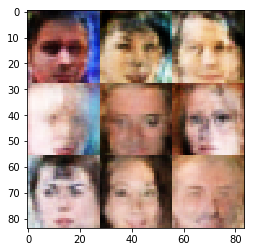

Epoch 1/1... Batch 3104/202599... Discriminator loss 1.3277... Generator loss 0.4485
Epoch 1/1... Batch 3136/202599... Discriminator loss 0.9310... Generator loss 0.5263


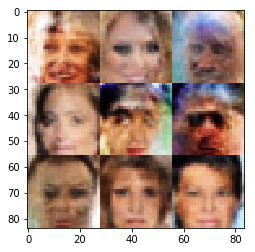

Checkpoint ./checkpoints/generator_celeba.ckpt saved.


In [146]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

#tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, 'celeba')

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.